# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [157]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

import time
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math

import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools
import plotly.io as pio
from IPython.display import Image

In [131]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

df = spark.read.json("mini_sparkify_event_data.json")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.createOrReplaceTempView("user_log_table")

In [5]:
spark.sql('''
          SELECT DISTINCT page
          FROM user_log_table 
          ORDER BY page ASC
          '''
          ).show(22)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [6]:
spark.sql('''
          Select page,count(*) pageVisited
          from user_log_table
          group by page
          ''').show(22)

+--------------------+-----------+
|                page|pageVisited|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      14457|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        924|
| Submit Registration|          5|
|            Settings|       1514|
|               Login|       3241|
|            Register|         18|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1726|
|             Upgrade|        499|
|               Error|        258|
|      Submit Upgrade|        159|
+--------------------+-----------+



In [7]:
spark.sql('''
          SELECT 'Missing userId' name,count(*) cnt
          FROM user_log_table 
          where userId is null or userId=''
          UNION
          SELECT 'Missing sessionId' name,count(*) cnt
          FROM user_log_table 
          where sessionId is null or sessionId=''
          UNION
          SELECT 'Missing level' name,count(*) cnt
          FROM user_log_table 
          where level is null or level=''
          UNION
          SELECT 'Missing page' name,count(*) cnt
          FROM user_log_table 
          where page is null or page=''
          '''
          ).show()

+-----------------+----+
|             name| cnt|
+-----------------+----+
|     Missing page|   0|
|   Missing userId|8346|
|    Missing level|   0|
|Missing sessionId|   0|
+-----------------+----+



In [8]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [9]:
cleanedData=spark.sql('''
                      SELECT *
                      FROM user_log_table 
                      where userId is not null and userId<>''
                      '''
                      )

cleanedData.createOrReplaceTempView("Cleaned_User_Log_Table")

In [10]:
spark.sql('''
          SELECT 'With Unregistered Users' tableDescription, count(*) RowCount
          FROM user_log_table 
          union
          SELECT 'Without Unregistered Users' tableDescription, count(*) RowCount
          FROM Cleaned_User_Log_Table
          '''
          ).show()

+--------------------+--------+
|    tableDescription|RowCount|
+--------------------+--------+
|Without Unregiste...|  278154|
|With Unregistered...|  286500|
+--------------------+--------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Defining Churn

In [11]:
table_with_churnTag=spark.sql('''
                   select ul.*,Churned from Cleaned_User_Log_Table ul
                   join 
                   (SELECT userId,
                   max(case when page='Cancellation Confirmation' then 1 else 0 end) Churned
                   FROM Cleaned_User_Log_Table
                   group by userId) ch on ul.userId=ch.userId
                   '''
                   )

table_with_churnTag.createOrReplaceTempView("Data_table")

#### Exploring Data

#### Data Exploration Calculations

In [12]:
DistinctCounts_pd=spark.sql('''
                         SELECT 'Number of Users' ColumnName,count( distinct userId) DistinctCount
                         FROM Data_table 
                         where userId is not null and userId<>''
                         UNION
                         SELECT 'Number of Artist' ColumnName,count( distinct artist) DistinctCount
                         FROM Data_table 
                         where artist is not null and artist<>''
                         UNION
                         SELECT 'Number of Pages' ColumnName,count( distinct page) DistinctCount
                         FROM Data_table 
                         where page is not null and page<>''
                         UNION
                         SELECT 'Number of Songs' ColumnName,count( distinct song) DistinctCount
                         FROM Data_table 
                         where song is not null and song<>''
                         '''
                         ).toPandas()

In [13]:
ChurnCounts_pd=spark.sql('''
                            SELECT case when Churned=1 then 'True' else 'False' end Churn, 
                            count(distinct userId) users
                            from Data_table
                            group by Churned
                            '''
                           ).toPandas()

In [47]:
labels = list(ChurnCounts_pd.Churn)
values = list(ChurnCounts_pd.users)
# figure
churnfig = {
  "data": [
    {
      "values": values,
      "labels": labels,
      "name": "Number Of Students Rates",
      "hole": .5,
      "type": "pie"
    },],
  "layout": {
        "title":"Churned vs Non Churned Users",
        "annotations": [
            { 
              "showarrow": False,
              "text": "Churned",
                "x": 1.1,
                "y": 1.05
            },
        ]
    }
}

In [152]:
pio.write_image(churnfig,'images/churnvsnonchurned.png')

In [56]:
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

<function __main__.<lambda>(x)>

In [16]:
Play_per_Hourspark=spark.sql('''
                             SELECT INT(get_hour(ts)) hour, count(*) plays_per_hour
                             FROM Data_Table 
                             where page='NextSong'
                             group by hour
                             order by hour
                             '''
                             ).toPandas()

In [17]:
# Creating trace1
trace = go.Scatter(
                    x = list(Play_per_Hourspark.hour),
                    y = list(Play_per_Hourspark.plays_per_hour),
                    mode = "lines",
                    name = "citations")

layout = dict(title = 'Playes Per Hour',
              xaxis= dict(title= 'Hour',ticklen= 5,zeroline= False)
             )
PPH_Fig = dict(data = [trace], layout = layout)

In [150]:
pio.write_image(PPH_Fig,'images/playsperhour.png')

In [18]:
spark.udf.register("get_week", lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%U'))


<function __main__.<lambda>(x)>

In [19]:
concurentusers=spark.sql('''
                         with userlevelperday as(
                         SELECT userid,get_week(ts) userweek,
                         min(case when level='free' then 0 else 1 end) levelforday
                         FROM Data_Table 
                         group by userid,userweek)
                          
                         select userweek,
                         sum(case when levelforday=1 then 1 else 0 end) PaidUsers,
                         sum(case when levelforday=0 then 1 else 0 end) FreeUsers
                         from userlevelperday
                         group by userweek
                         order by userweek
                         '''
                         ).toPandas()

In [20]:
# Creating trace1
trace1 = go.Scatter(
                    x = concurentusers.loc[concurentusers.PaidUsers>=2].userweek,
                    y = concurentusers.loc[concurentusers.PaidUsers>=2].PaidUsers,
                    mode = "lines+markers",
                    name = "Paid Users")
# Creating trace2
trace2 = go.Scatter(
                    x = concurentusers.loc[concurentusers.FreeUsers>=2].userweek,
                    y = concurentusers.loc[concurentusers.FreeUsers>=2].FreeUsers,
                    mode = "lines+markers",
                    name = "Free Users")
data = [trace1, trace2]
layout = dict(title = 'Users That Logged In Per Week',
              xaxis= dict(title= 'Date (Year-Week)'),
              yaxis= dict(title= 'User Logins'),
              margin=dict(b=110)
             )

LPW_Fig = dict(data = data, layout = layout)

In [165]:
pio.write_image(LPW_Fig,'images/usersperweek.png')

In [21]:
churnperweek=spark.sql('''
                       Select level, get_week(ts) userweek, count(*) churnedUsers
                       from Data_Table
                       where page='Cancellation Confirmation'
                       group by level,userweek
                       order by level,userweek
                       ''').toPandas()

In [22]:
# Creating trace1
trace1 = go.Scatter(
                    x = churnperweek.loc[churnperweek.level=='paid'].userweek,
                    y = churnperweek.loc[churnperweek.level=='paid'].churnedUsers,
                    mode = "lines+markers",
                    name = "Paid Users")
# Creating trace2
trace2 = go.Scatter(
                    x = churnperweek.loc[churnperweek.level=='free'].userweek,
                    y = churnperweek.loc[churnperweek.level=='free'].churnedUsers,
                    mode = "lines+markers",
                    name = "Free Users")
data = [trace1, trace2]
layout = dict(title = 'Users Churned Per Week',
              xaxis= dict(title= 'Date (Year-Week)'),
              yaxis= dict(title= 'Users Churned'),
              margin=dict(b=110)
             )

CPW_Fig = dict(data = data, layout = layout)

In [149]:
pio.write_image(CPW_Fig,'images/churnperweek.png')

In [23]:
genderchurn=spark.sql('''
                      Select case when gender='M' then 'Male' else 'Female'end gender,
                      case when Churned=1 then 'True' else 'False'end Churned,
                      count(distinct userid) UserCount
                      from Data_Table
                      group by gender,Churned
                      order by gender,Churned
                      ''').toPandas()

In [24]:
genders=genderchurn.gender.unique()
percChurn=[]

for i in genders:
    gendercounts=genderchurn.loc[genderchurn.gender==i]
    totalusers=gendercounts.sum().UserCount
    churnedUsers=gendercounts.loc[gendercounts.Churned=='True'].sum().UserCount
    percChurn.append(round((churnedUsers/totalusers)*100,2))

trace1 = {
  'x': genders,
  'y': percChurn,
  'name': 'citation',
  'type': 'bar'
};
layout = {
  'xaxis': {'title':'Gender'},
  'yaxis': {'title':'Percentage Churn (%)'},
  'title': 'Percentage Churn per Gender'
};
CPG_fig = go.Figure(data = [trace1], layout = layout)

In [148]:
pio.write_image(CPG_fig,'images/genderchurn.png')

In [25]:
locationsDF=spark.sql('''
                    select locationState,
                    round(sum(case when Churned=1 then users else 0 end)/sum(users)*100,2) percChurn,
                    sum(users) users
                    from(
                    SELECT right(location,2) locationState,Churned, count(distinct userId) users
                    FROM Data_table 
                    group by locationState,Churned)x
                    group by locationState
                    '''
                    ).toPandas()

In [54]:
trc=dict(
    type='choropleth',
    locations=list(locationsDF.loc[locationsDF.users>=5].locationState),
    locationmode='USA-states',
    colorscale=['Viridis'],
    z=list(locationsDF.loc[locationsDF.users>=5].percChurn))

lyt=dict( geo=dict(scope='usa'), title='User Churn Percentage Per State')
Churnmap=go.Figure(data=[trc],layout=lyt)

In [153]:
pio.write_image(Churnmap,'images/Churnperstate.png')

In [26]:
trc=dict(
    type='choropleth',
    locations=list(locationsDF.locationState),
    locationmode='USA-states',
    colorscale=['Viridis'],
    z=list(locationsDF.users))

lyt=dict( geo=dict(scope='usa'), title='Users Per State')
map=go.Figure(data=[trc],layout=lyt)

In [154]:
pio.write_image(map,'images/usersperstate.png')

### DataExploration Start

In [27]:
spark.sql('''
        SELECT userId,count(distinct location)locationCount
        FROM Data_table 
        group by userId
        order by locationCount desc
        '''
        ).show()

+------+-------------+
|userId|locationCount|
+------+-------------+
|100010|            1|
|200002|            1|
|   125|            1|
|   124|            1|
|    51|            1|
|     7|            1|
|    15|            1|
|    54|            1|
|   155|            1|
|100014|            1|
|   132|            1|
|   154|            1|
|   101|            1|
|    11|            1|
|   138|            1|
|300017|            1|
|100021|            1|
|    29|            1|
|    69|            1|
|   112|            1|
+------+-------------+
only showing top 20 rows



Since there is no users that changed location, I'm going to assume that users will stay in the same state if I include location as a feature. 

In [28]:
spark.sql('''
          Select userId, level, page, Churned,ts
          from Data_Table
          where page in 
          ('Submit Downgrade',
          'Submit Upgrade',
          'Submit Registration',
          'Cancellation Confirmation')
          order by userId,ts
          ''').show(20)

+------+-----+--------------------+-------+-------------+
|userId|level|                page|Churned|           ts|
+------+-----+--------------------+-------+-------------+
|   100| paid|    Submit Downgrade|      0|1541367880000|
|   100| free|      Submit Upgrade|      0|1542215545000|
|100001| free|Cancellation Conf...|      1|1538498205000|
|100003| free|Cancellation Conf...|      1|1539274781000|
|100004| free|      Submit Upgrade|      0|1539577249000|
|100004| paid|    Submit Downgrade|      0|1539868732000|
|100004| free|      Submit Upgrade|      0|1539880189000|
|100004| paid|    Submit Downgrade|      0|1540975222000|
|100004| free|      Submit Upgrade|      0|1543328769000|
|100005| free|Cancellation Conf...|      1|1539971825000|
|100006| free|Cancellation Conf...|      1|1538753070000|
|100007| paid|Cancellation Conf...|      1|1543491909000|
|100008| paid|    Submit Downgrade|      0|1542748901000|
|100009| free|      Submit Upgrade|      1|1539556743000|
|100009| paid|

In [29]:
spark.sql('''
          Select Churned,avg(errorcount)
          from(
          Select userId,Churned,count(*) errorcount
          from Data_Table
          where page='Error'
          group by userId,Churned)x
          group by Churned
          ''').show(20)

+-------+------------------+
|Churned|   avg(errorcount)|
+-------+------------------+
|      1|1.4545454545454546|
|      0|2.3157894736842106|
+-------+------------------+



Since Average Errors is higher for non churned users, I don't expect it to have an impact on churn

In [30]:
DistinctCounts_pd

,ColumnName,DistinctCount
0,Number of Users,225
1,Number of Artist,17655
2,Number of Songs,58480
3,Number of Pages,19


In [31]:
ChurnCounts_pd

,Churn,users
0,True,52
1,False,173


In [32]:
churnperweek.groupby('level').sum()

,churnedUsers
level,
free,21
paid,31


We can see that there is an distinction in churn between paid and free users. I will therefore include level as a feature

In [33]:
spark.sql('''
          SELECT count(*) Downgrades,count(distinct userId) DistinctUserDowngrades
          from Data_Table
          where page='Submit Downgrade'
          '''
          ).show()

+----------+----------------------+
|Downgrades|DistinctUserDowngrades|
+----------+----------------------+
|        63|                    49|
+----------+----------------------+



In [34]:
spark.sql('''
          SELECT count(*) Upgrades,count(distinct userId) DistinctUserUpgrades
          from Data_Table
          where page='Submit Upgrade'
          '''
          ).show()

+--------+--------------------+
|Upgrades|DistinctUserUpgrades|
+--------+--------------------+
|     159|                 131|
+--------+--------------------+



Here we can see that some users upgraded and downgraded a couple of times. It might be worth investigating if users that does this are prone to churn as well.

In [35]:
spark.udf.register("get_date", lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))

<function __main__.<lambda>(x)>

In [36]:
spark.sql('''
          SELECT 'Song Played' Name,min(get_date(ts)) min_date,max(get_date(ts)) max_date
          FROM Data_Table 
          UNION
          SELECT 'User Registered' Name,min(get_date(registration)) min_date,max(get_date(registration)) max_date
          FROM Data_Table 
          '''
          ).show()

+---------------+----------+----------+
|           Name|  min_date|  max_date|
+---------------+----------+----------+
|    Song Played|2018-10-01|2018-12-03|
|User Registered|2018-03-18|2018-11-26|
+---------------+----------+----------+



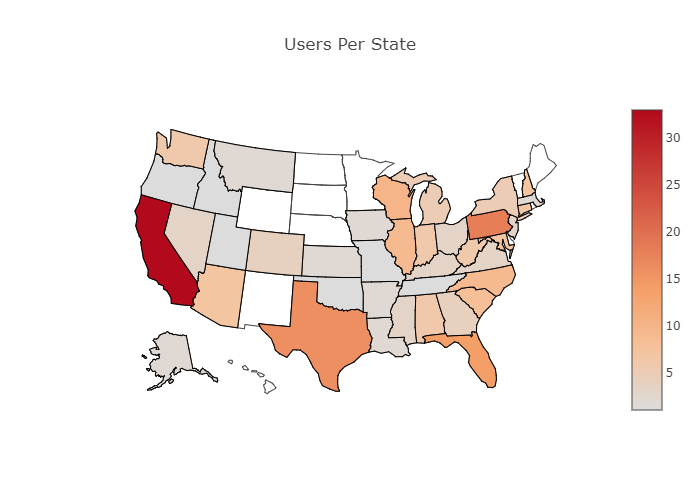

In [160]:
Image("images/usersperstate.png")

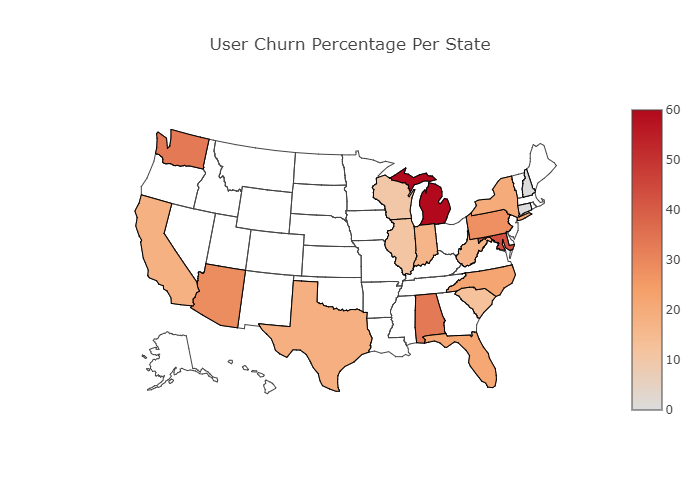

In [161]:
Image("images/Churnperstate.png")

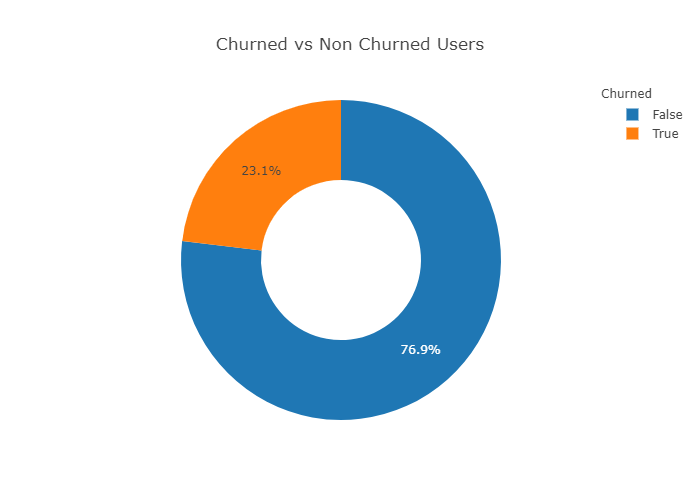

In [162]:
Image("images/churnvsnonchurned.png")

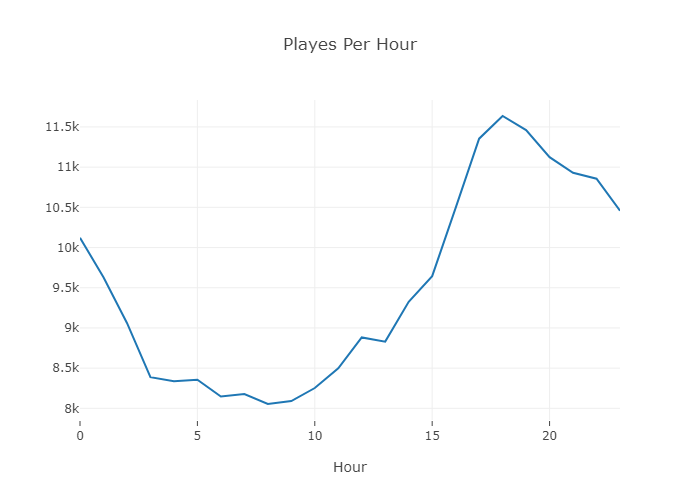

In [163]:
Image("images/playsperhour.png")

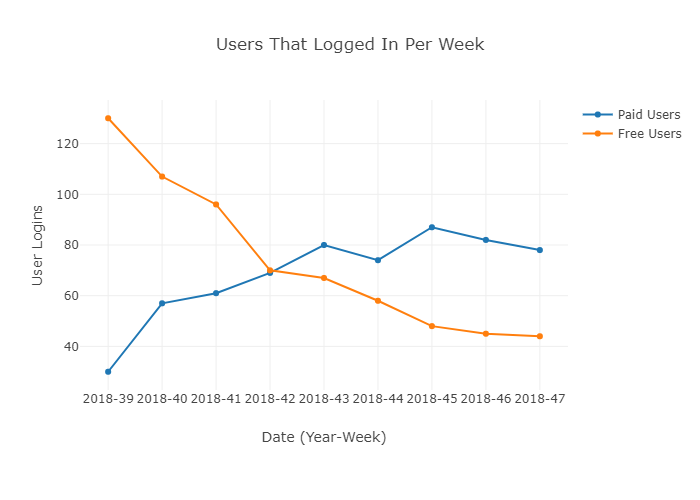

In [166]:
Image("images/usersperweek.png")

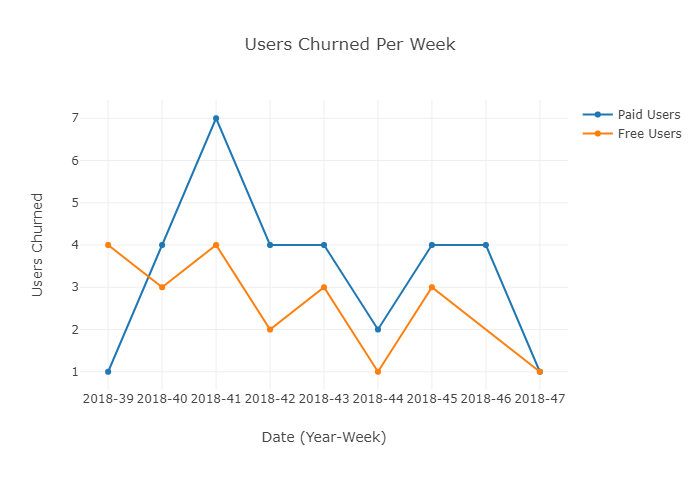

In [167]:
Image("images/churnperweek.png")

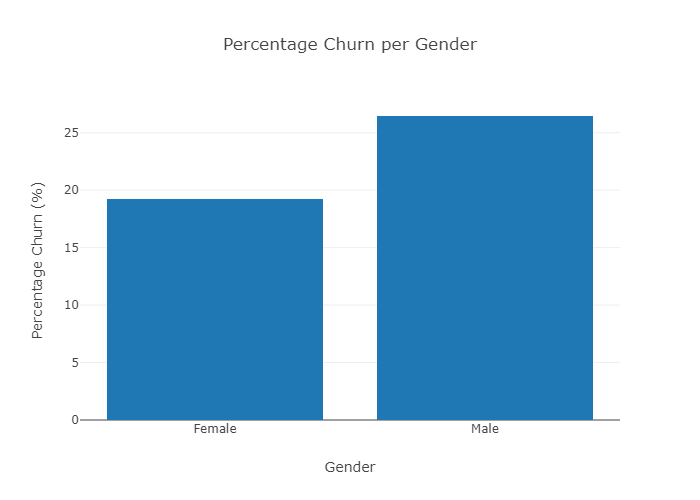

In [169]:
Image("images/genderchurn.png")

Days since subscription

In [57]:
spark.udf.register("sec_diff", lambda maxdate, mindate: 
                   (datetime.datetime.fromtimestamp(maxdate / 1000.0)-
                    datetime.datetime.fromtimestamp(mindate / 1000.0)).total_seconds())

<function __main__.<lambda>(maxdate, mindate)>

In [58]:
spark.udf.register("days_diff", lambda maxdate, mindate: 
                   (datetime.datetime.fromtimestamp(maxdate / 1000.0)-
                    datetime.datetime.fromtimestamp(mindate / 1000.0)).days())

<function __main__.<lambda>(maxdate, mindate)>

In [59]:
def join_tables(t1,t2):
    return t1.join(t2,t1.userId == t2.table_userId, "left").drop("table_userId")

In [60]:
userFeatures=spark.sql('''
                      SELECT userId,
                      datediff(from_unixtime(max(ts)/1000),
                      from_unixtime(min(registration)/1000)) DaysSinceSub,
                      gender,Churned,count(distinct sessionId) Sessions
                      FROM Data_Table 
                      group by userId,gender,Churned
                      '''
                      )

userFeatures.createOrReplaceTempView("userFeatures")

userLevel_State=spark.sql('''
                  select dt.userId table_userId,level,State
                  from(
                  select userId,level,right(location,2) State,
                  ROW_NUMBER() OVER(PARTITION BY userId ORDER BY ts) rownr
                  from Data_Table) dt
                  join(
                  select userId,count(*) cnt from Data_Table
                  group by userId) userMaxRows
                  on dt.userId=userMaxRows.userId and userMaxRows.cnt=dt.rownr
                  '''
                  )

userFeatures=join_tables(userFeatures,userLevel_State)

Sessionstats=spark.sql('''
                      select userId table_userId,avg(SessionLength) Avg_SessionLength, 
                      avg(SongsInSession) Avg_SongsInSession,
                      sum(SongsInSession) Total_Songs
                      from(
                      SELECT userId,sessionId,
                      sec_diff(max(ts),min(ts)) SessionLength,
                      count(*) as SongsInSession
                      FROM Data_Table 
                      where page='NextSong'
                      group by userId,sessionId)x
                      group by userId
                      '''
                      )

userFeatures=join_tables(userFeatures,Sessionstats)

sessiondiffernce=spark.sql('''
                            With sessionStart_EndTimes as (
                            select userID,sessionId,max(ts) End_time,min(ts) Start_time
                            from Data_Table
                            group by userId,sessionId),
                            sessionVSprevSession as (
                            select userId,sessionId,Start_time,
                            LAG(End_time, 1,0) OVER (Partition by userid ORDER BY End_time) PreviousSessionEnd
                            from sessionStart_EndTimes)

                            select userId table_userId,avg(sec_diff(Start_time,PreviousSessionEnd)) AvgTimeBetweenSessions
                            from sessionVSprevSession
                            where PreviousSessionEnd<>0
                            group by userId
                            '''
                            )

userFeatures=join_tables(userFeatures,sessiondiffernce)

PageVisits=spark.sql('''
                      select userId table_userId,
                      sum(case when page='Add Friend' then 1 else 0 end) Friends,
                      sum(case when page='Help' then 1 else 0 end) HelpVisited,
                      sum(case when page='Settings' then 1 else 0 end) SettingsVisited,
                      sum(case when page='Add to Playlist' then 1 else 0 end) SongsInPlaylist,
                      sum(case when page='Roll Advert' then 1 else 0 end) AdvertsSeen
                      from Data_Table
                      where page in 
                      ('Help',
                      'Settings',
                      'Add to Playlist',
                      'Add Friend',
                      'Roll Advert')
                      group by userId
                      '''
                      )

userFeatures=join_tables(userFeatures,PageVisits)

UserLikes=spark.sql('''
                      select userId table_userId, Likes,Dislikes, 
                      case when Dislikes=0 then Likes
                      when Likes=0 then 1/Dislikes
                      else Likes/Dislikes end LikeRatio
                      from (
                      select userId,sum(case when page='Thumbs Up' then 1 else 0 end) Likes,
                      sum(case when page='Thumbs Down' then 1 else 0 end) Dislikes
                      from Data_Table
                      where page in ('Thumbs Down','Thumbs Up','Add Friend')
                      group by userId)
                      '''
                      )

userFeatures=join_tables(userFeatures,UserLikes)

consecutiveLogins=spark.sql('''
                  with usagedates as(
                  select userId,get_date(ts) date
                  from Data_Table
                  group by userId,date
                  order by date),
                  sessionDates as (
                  select userId,date,
                  LAG(date, 1,0) OVER (Partition by userid ORDER BY date) PreviousSession
                  from usagedates),
                  sessiondaysDifference as (
                  select userId,date,PreviousSession, datediff(date,PreviousSession) daysdif
                  from sessionDates),
                  runningCount as (
                  select userId,
                  row_number() over (partition by userId,grp order by date) - 1 as running_count
                  from (select *,
                  sum(case when daysdif <> 1 then 1 else 0 end) over (partition by userId order by date) as grp
                  from sessiondaysDifference
                  ) t)

                  select userId table_userId,max(running_count) as ConsecutiveLogins from runningCount
                  group by userId
                  '''
                  )

userFeatures=join_tables(userFeatures,consecutiveLogins)

userFeatures.createOrReplaceTempView("userFeatures")

In [61]:
start = time.time()
userFeatures.createOrReplaceTempView("userFeatures")
userstats=userFeatures.toPandas()
print('It took', time.time()-start, 'seconds.')

It took 123.71116018295288 seconds.


In [173]:
def createmultiplots(l):
    data=[]
    j=0
    titles=[]
    for i in range(0,len(l)):
        titles.append(l[i][2])
        if i%3==0:
            j=0
        data.append(go.Box(
            y=l[i][0],
            xaxis='x'+str(i+1),
            yaxis='y'+str(i+1),
            name='True',
            boxpoints='all'
        ))
        data.append(go.Box(
            y=l[i][1],
            xaxis='x'+str(i+1),
            yaxis='y'+str(i+1),
            name='False',
            boxpoints='all'
        ))
        j+=1
    
    fig = tools.make_subplots(rows=int(len(l)/3), cols=3, subplot_titles=titles, print_grid=False)
    k=1
    g=0
    m=1
    for h in range(0,len(l)):
        if h%3==0 and h!=0:
            k+=1
            m=1
        fig.append_trace(data[g], k, m)
        g+=1
        fig.append_trace(data[g], k, m)
        g+=1
        m+=1


    fig['layout'].update(showlegend=False,
    autosize=False,
    width=1000,
    height=2000)

    return fig

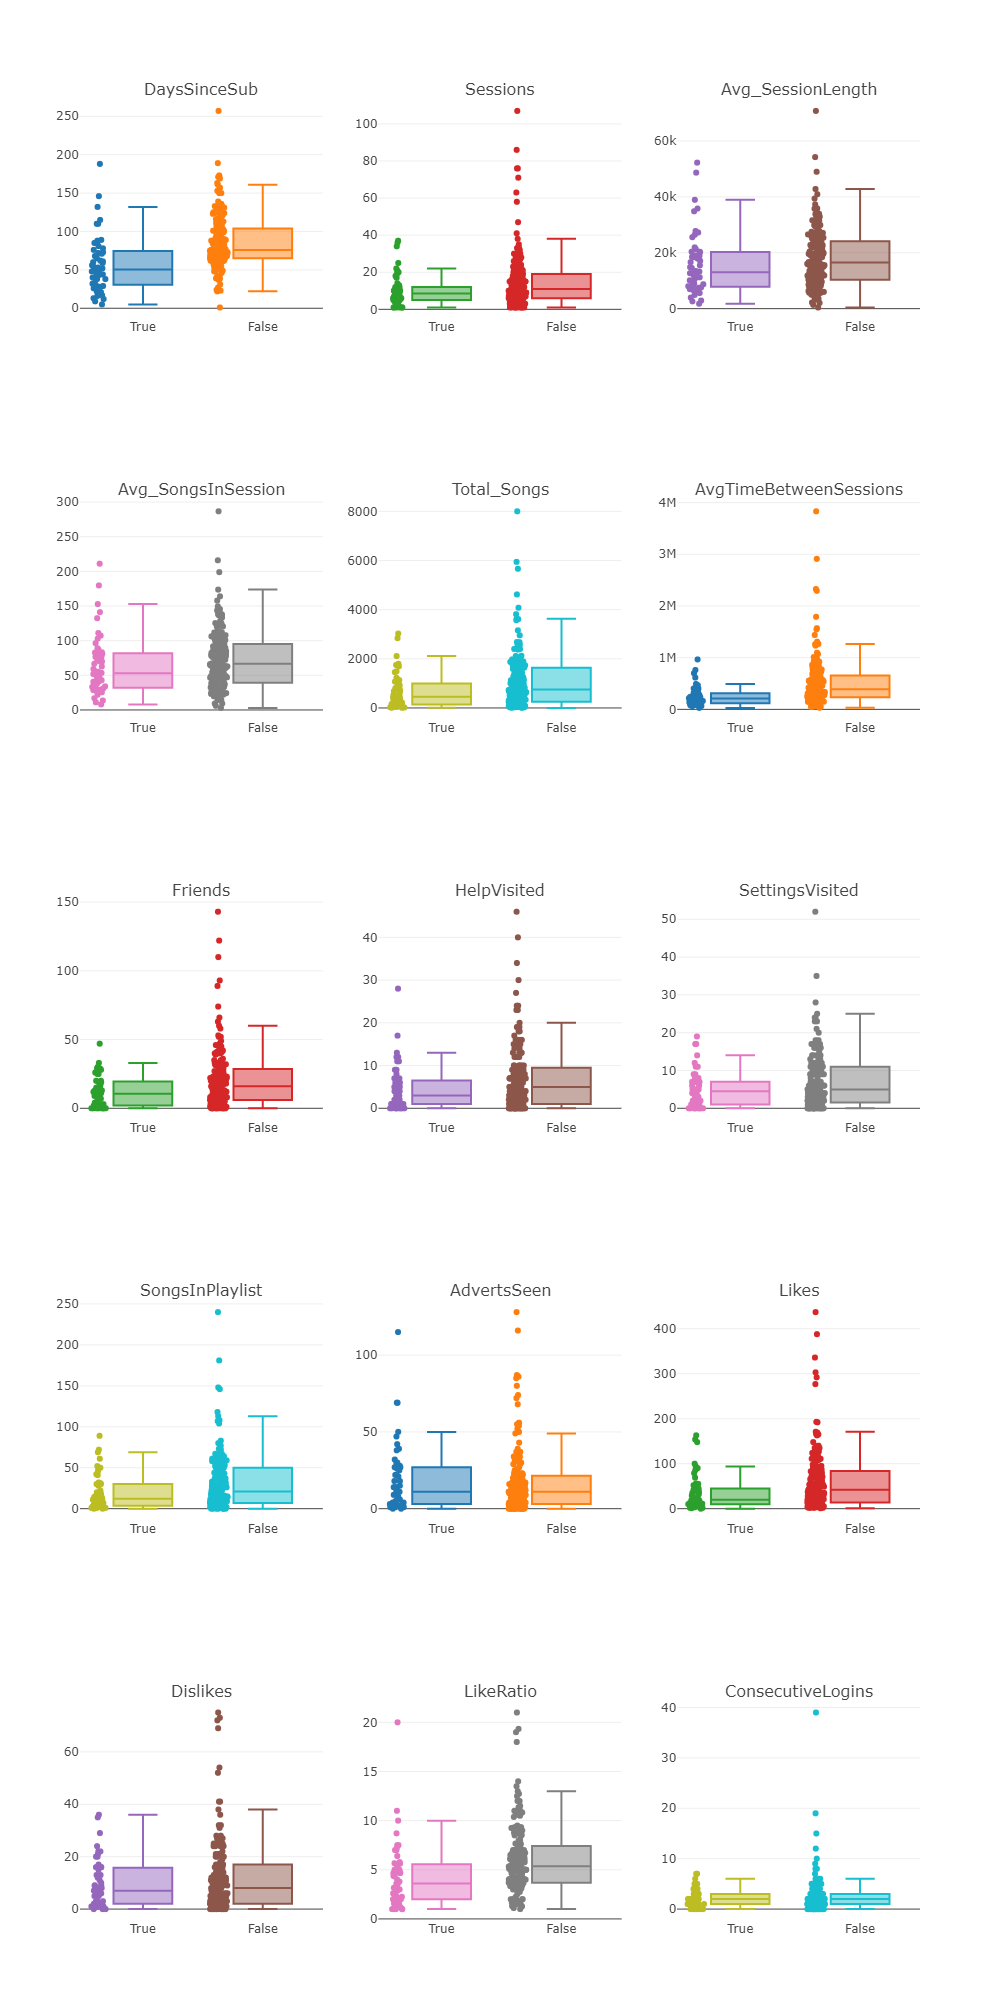

In [182]:
cols=list(userstats.describe().columns)
cols.remove('Churned')
data=[]
for i in range(1,math.ceil(len(cols)/3)+1):
    cols_to_Include=cols[(i*3)-3:i*3]
    for j in cols_to_Include:
        y0 = list(userstats.loc[userstats.Churned==1][j])
        y1 = list(userstats.loc[userstats.Churned==0][j])
        data.append([y0,y1,j])
pio.write_image(createmultiplots(data),'images/Multipleboxplots.png')
Image("images/Multipleboxplots.png")

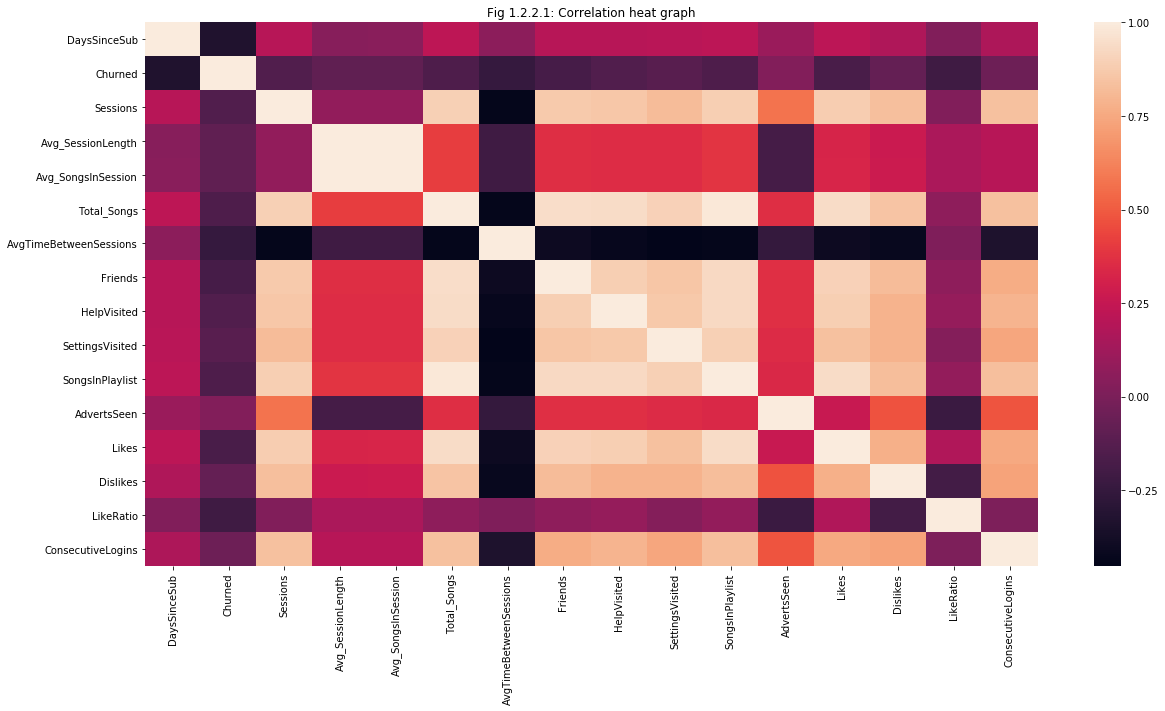

,DaysSinceSub,Churned,Sessions,Avg_SessionLength,Avg_SongsInSession,Total_Songs,AvgTimeBetweenSessions,Friends,HelpVisited,SettingsVisited,SongsInPlaylist,AdvertsSeen,Likes,Dislikes,LikeRatio,ConsecutiveLogins
DaysSinceSub,1.000000,-0.328207,0.204447,0.044883,0.049481,0.226110,0.062818,0.203723,0.201211,0.208337,0.218719,0.108224,0.220381,0.174451,0.020850,0.167023
Churned,-0.328207,1.000000,-0.142129,-0.090250,-0.093513,-0.156110,-0.243006,-0.183696,-0.144116,-0.123604,-0.154425,0.026526,-0.170134,-0.075183,-0.212678,-0.046778
Sessions,0.204447,-0.142129,1.000000,0.075044,0.076850,0.896453,-0.439582,0.870612,0.862600,0.823469,0.891161,0.568833,0.881738,0.830139,0.023281,0.836347
Avg_SessionLength,0.044883,-0.090250,0.075044,1.000000,0.996561,0.410533,-0.209654,0.359020,0.353038,0.355382,0.382599,-0.187988,0.324133,0.269287,0.161846,0.204818
Avg_SongsInSession,0.049481,-0.093513,0.076850,0.996561,1.000000,0.412326,-0.209139,0.360134,0.355254,0.358248,0.384217,-0.187006,0.324946,0.275819,0.160189,0.205327
Total_Songs,0.226110,-0.156110,0.896453,0.410533,0.412326,1.000000,-0.439036,0.946529,0.940921,0.902405,0.986379,0.360685,0.940386,0.849759,0.065978,0.838480
AvgTimeBetweenSessions,0.062818,-0.243006,-0.439582,-0.209654,-0.209139,-0.439036,1.000000,-0.402783,-0.427978,-0.452983,-0.439551,-0.254083,-0.406784,-0.421584,0.013897,-0.337461
Friends,0.203723,-0.183696,0.870612,0.359020,0.360134,0.946529,-0.402783,1.000000,0.888768,0.855068,0.929250,0.365730,0.901467,0.821102,0.067742,0.766033
HelpVisited,0.201211,-0.144116,0.862600,0.353038,0.355254,0.940921,-0.427978,0.888768,1.000000,0.867236,0.928720,0.367588,0.888408,0.786092,0.089515,0.792603
SettingsVisited,0.208337,-0.123604,0.823469,0.355382,0.358248,0.902405,-0.452983,0.855068,0.867236,1.000000,0.896569,0.348992,0.836019,0.784366,0.034786,0.743275


In [179]:
# calculate the correlation matrix
corr=userstats[userstats.columns].corr()

# plot the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Fig 1.2.2.1: Correlation heat graph')
plt.savefig("images/correlationbefore.png")
plt.show()
corr

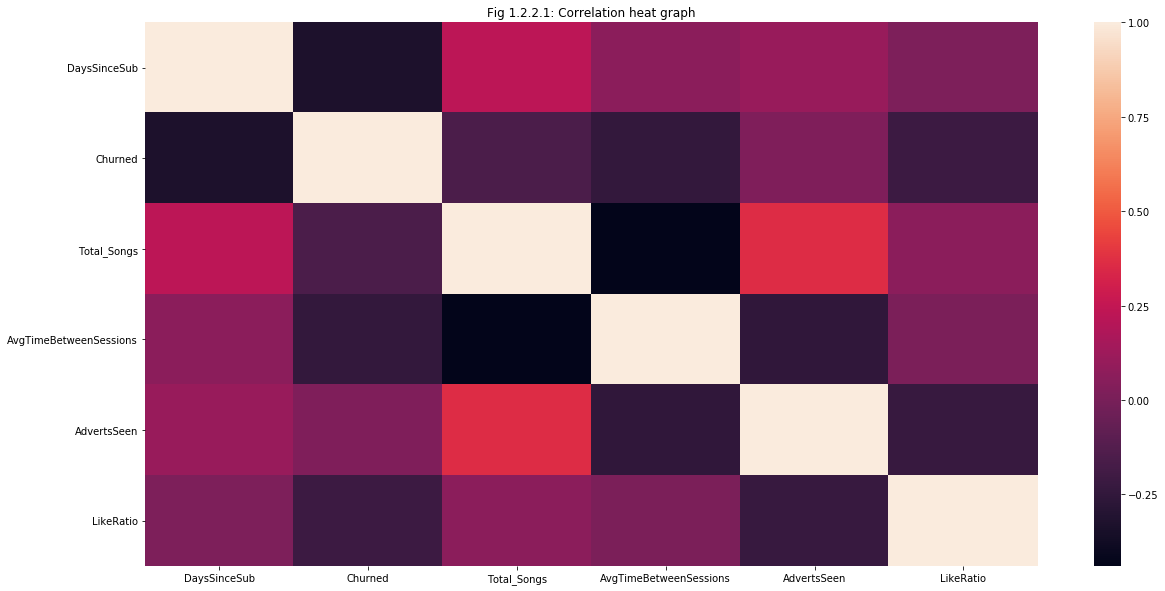

,DaysSinceSub,Churned,Total_Songs,AvgTimeBetweenSessions,AdvertsSeen,LikeRatio
DaysSinceSub,1.000000,-0.328207,0.226110,0.062818,0.108224,0.020850
Churned,-0.328207,1.000000,-0.156110,-0.243006,0.026526,-0.212678
Total_Songs,0.226110,-0.156110,1.000000,-0.439036,0.360685,0.065978
AvgTimeBetweenSessions,0.062818,-0.243006,-0.439036,1.000000,-0.254083,0.013897
AdvertsSeen,0.108224,0.026526,0.360685,-0.254083,1.000000,-0.230471
LikeRatio,0.020850,-0.212678,0.065978,0.013897,-0.230471,1.000000


In [178]:
FeaturesToKeep=['DaysSinceSub','Total_Songs','LikeRatio','AdvertsSeen','AvgTimeBetweenSessions','Churned']

corr1=userstats.loc[:,userstats.columns.isin(FeaturesToKeep)].corr()

# plot the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr1, 
        xticklabels=corr1.columns,
        yticklabels=corr1.columns)
plt.title('Fig 1.2.2.1: Correlation heat graph')
plt.savefig("images/correlationafter.png")
plt.show()
corr1

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features to include:
* Days since subscription
* Total songs
* Liking/Disliking ratio
* Adverts Seen
* Average Time between sessions
* State
* Gender
* Latest Level

#### Features I'm excluding after analysis:
* City
* Amount of Error Pages
* Average session length 
* Average session song count
* Help visited number of times
* Number of sessions
* Setting page views
* Elements in playlist
* Liking/Disliking count
* Amount of friends
* About Page Visits
* Max consecutive days logged in

In [2]:
def feature_engineering(filepath):
    spark = SparkSession \
            .builder \
            .appName("Sparkify Churn Prediction") \
            .getOrCreate()

    df = spark.read.json(filepath)
    
    df.createOrReplaceTempView("user_log_table")
    
    cleanedData=spark.sql('''
                          SELECT *
                          FROM user_log_table 
                          where userId is not null and userId<>''
                          '''
                          )

    cleanedData.createOrReplaceTempView("Cleaned_User_Log_Table")

    table_with_churnTag=spark.sql('''
                                  select ul.*,Churned from Cleaned_User_Log_Table ul
                                  join 
                                  (SELECT userId,
                                  max(case when page='Cancellation Confirmation' then 1 else 0 end) Churned
                                  FROM Cleaned_User_Log_Table
                                  group by userId) ch on ul.userId=ch.userId
                                  '''
                                  )

    table_with_churnTag.createOrReplaceTempView("Data_table")
    
    userFeatures=spark.sql('''
                          SELECT userId,
                          datediff(from_unixtime(max(ts)/1000),
                          from_unixtime(min(registration)/1000)) DaysSinceSub
                          FROM Data_Table 
                          group by userId
                          '''
                          )

    userFeatures.createOrReplaceTempView("userFeatures")

    userLevel_State=spark.sql('''
                      select dt.userId table_userId,State,Churned label,
                      case when gender='M' then 1 else 0 end 
                      gender,
                      case when level='paid' then 1 else 0 end 
                      level
                      from(
                      select userId,level,right(location,2) State,gender,Churned,
                      ROW_NUMBER() OVER(PARTITION BY userId ORDER BY ts) rownr
                      from Data_Table) dt
                      join(
                      select userId,count(*) cnt from Data_Table
                      group by userId) userMaxRows
                      on dt.userId=userMaxRows.userId and userMaxRows.cnt=dt.rownr
                      '''
                      )

    Sessionstats=spark.sql('''
                          select userId table_userId,
                          count(*) Total_Songs
                          FROM Data_Table 
                          where page='NextSong'
                          group by userId
                          '''
                          )

    sessiondiffernce=spark.sql('''
                            With sessionStart_EndTimes as (
                            select userID,sessionId,max(ts) End_time,min(ts) Start_time
                            from Data_Table
                            group by userId,sessionId),
                            sessionVSprevSession as (
                            select userId,sessionId,Start_time,
                            LAG(End_time, 1,0) OVER (Partition by userid ORDER BY End_time) PreviousSessionEnd
                            from sessionStart_EndTimes)

                            select userId table_userId,avg(sec_diff(Start_time,PreviousSessionEnd)) AvgTimeBetweenSessions
                            from sessionVSprevSession
                            where PreviousSessionEnd<>0
                            group by userId
                            '''
                            )

    PageVisits=spark.sql('''
                          select userId table_userId,
                          sum(case when page='Roll Advert' then 1 else 0 end) AdvertsSeen
                          from Data_Table
                          where page = 'Roll Advert'
                          group by userId
                          '''
                          )

    UserLikes=spark.sql('''
                          select userId table_userId,
                          case when Dislikes=0 then Likes
                          when Likes=0 then 1/Dislikes
                          else Likes/Dislikes end LikeRatio
                          from (
                          select userId,sum(case when page='Thumbs Up' then 1 else 0 end) Likes,
                          sum(case when page='Thumbs Down' then 1 else 0 end) Dislikes
                          from Data_Table
                          where page in ('Thumbs Down','Thumbs Up','Add Friend')
                          group by userId)
                          '''
                          )
    
    userFeatures=join_tables(userFeatures,userLevel_State)
    userFeatures=join_tables(userFeatures,Sessionstats)
    userFeatures=join_tables(userFeatures,sessiondiffernce)
    userFeatures=join_tables(userFeatures,PageVisits)
    userFeatures=join_tables(userFeatures,UserLikes)
    
    statesFeatures=userFeatures.groupBy('userId').pivot('State').agg(count('State')) \
                            .fillna(0).withColumnRenamed("userId", "table_userId")
    
    userFeatures=join_tables(userFeatures,statesFeatures).drop("State").fillna(0)

    return userFeatures

In [6]:
spark.udf.register("sec_diff", lambda maxdate, mindate: 
                   (datetime.datetime.fromtimestamp(maxdate / 1000.0)-
                    datetime.datetime.fromtimestamp(mindate / 1000.0)).total_seconds())
spark.udf.register("days_diff", lambda maxdate, mindate: 
                   (datetime.datetime.fromtimestamp(maxdate / 1000.0)-
                    datetime.datetime.fromtimestamp(mindate / 1000.0)).days())
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

def join_tables(t1,t2):
    return t1.join(t2,t1.userId == t2.table_userId, "left").drop("table_userId")

In [7]:
filepath="mini_sparkify_event_data.json"
start = time.time()
userFeaturesNew=feature_engineering(filepath)
print('It took', time.time()-start, 'seconds.')
df_Cols=userFeaturesNew.columns
featurecols=[x for x in df_Cols if x not in ['userId','label']]

It took 81.70588731765747 seconds.


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer,MaxAbsScaler, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark.sql.functions as f
from functools import reduce

In [9]:
# Defining Evaluation function
f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [10]:
train_set, validation_set = userFeaturesNew.randomSplit([0.8, 0.2], seed=42)
train_set.cache()

DataFrame[userId: string, DaysSinceSub: int, label: int, gender: int, level: int, Total_Songs: bigint, AvgTimeBetweenSessions: double, AdvertsSeen: bigint, LikeRatio: double, AK: bigint, AL: bigint, AR: bigint, AZ: bigint, CA: bigint, CO: bigint, CT: bigint, FL: bigint, GA: bigint, IA: bigint, ID: bigint, IL: bigint, IN: bigint, KS: bigint, KY: bigint, LA: bigint, MA: bigint, MD: bigint, MI: bigint, MO: bigint, MS: bigint, MT: bigint, NC: bigint, NH: bigint, NJ: bigint, NV: bigint, NY: bigint, OH: bigint, OK: bigint, OR: bigint, PA: bigint, SC: bigint, TN: bigint, TX: bigint, UT: bigint, VA: bigint, WA: bigint, WI: bigint, WV: bigint]

In [9]:
classifiers=[GBTClassifier(),
             RandomForestClassifier(),
             LinearSVC(),
             LogisticRegression()]

In [11]:
def buildpipeline(classifier):
    assembler = VectorAssembler(inputCols=featurecols, outputCol="Features")
    scaler = MaxAbsScaler(inputCol="Features", outputCol="features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])
    return pipeline

In [11]:
resultsdict={'Classifier':[],'F1_Score_Train':[],'F1_Score_Test':[],'Training_Time':[]}

In [13]:
for classifier in classifiers:
    print("Classifier: ",str(classifier).split('_')[0])
    pipeline=buildpipeline(classifier)
    start = time.time()
    fittedModel = pipeline.fit(train_set)
    Prediction_Time = time.time()-start
    trainPred = fittedModel.transform(train_set)
    trainf1=f1Evaluator.evaluate(trainPred)
    print("F1 score Train: ",trainf1)
    valPred = fittedModel.transform(validation_set)
    valf1=f1Evaluator.evaluate(valPred)
    print("F1 score Test: ",valf1)
    resultsdict['Classifier'].append(str(classifier).split('_')[0])
    resultsdict['F1_Score_Train'].append(trainf1)
    resultsdict['F1_Score_Test'].append(valf1)
    resultsdict['Training_Time'].append(Prediction_Time)

Classifier:  GBTClassifier
F1 score Train:  1.0
F1 score Test:  0.8004201680672269
Classifier:  RandomForestClassifier
F1 score Train:  0.8898467816089446
F1 score Test:  0.8259686649779528
Classifier:  LinearSVC
F1 score Train:  0.868357462322742
F1 score Test:  0.7262656475019387
Classifier:  LogisticRegression
F1 score Train:  0.8573872508496373
F1 score Test:  0.7797160243407708


In [14]:
resultsdict

{'Classifier': ['GBTClassifier',
  'RandomForestClassifier',
  'LinearSVC',
  'LogisticRegression'],
 'F1_Score_Train': [1.0,
  0.8898467816089446,
  0.868357462322742,
  0.8573872508496373],
 'F1_Score_Test': [0.8004201680672269,
  0.8259686649779528,
  0.7262656475019387,
  0.7797160243407708],
 'Training_Time': [698.0813415050507,
  49.9203941822052,
  916.8303740024567,
  222.24748063087463]}

In [12]:
classifier=RandomForestClassifier()
RF_Pipeline = buildpipeline(classifier)
paramGrid = ParamGridBuilder() \
      .addGrid(classifier.impurity, ["gini", "entropy"]) \
      .addGrid(classifier.maxDepth, [2,5, 10]) \
    .build()
crossval = CrossValidator(estimator=RF_Pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cv_RF = crossval.fit(train_set)

In [15]:
bestModel = cv_RF.bestModel

In [14]:
f1Evaluator.evaluate(cv_RF.transform(validation_set))

0.8669467787114846

In [141]:
resultsdf=pd.DataFrame.from_dict(resultsdict).sort_values(by='F1_Score_Test',ascending=False)

In [142]:
resultsdf

,Classifier,F1_Score_Train,F1_Score_Test,Training_Time
1,RandomForestClassifier,0.889847,0.825969,49.920394
0,GBTClassifier,1.000000,0.800420,698.081342
3,LogisticRegression,0.857387,0.779716,222.247481
2,LinearSVC,0.868357,0.726266,916.830374


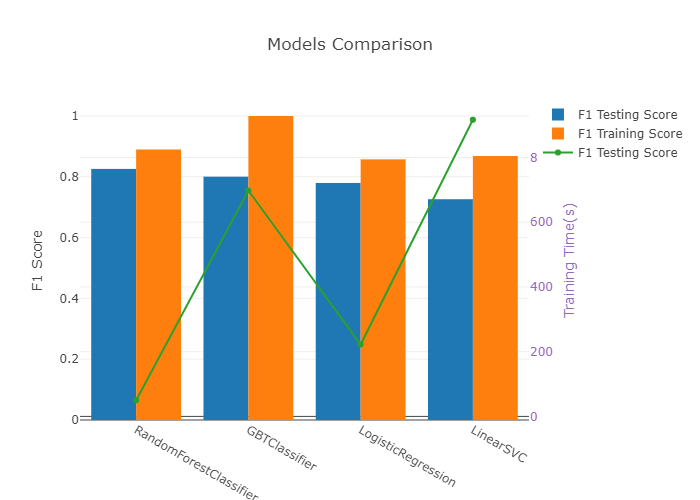

In [181]:
trace1 = go.Bar(
    x=list(resultsdf.Classifier),
    y=list(resultsdf.F1_Score_Train),
    name='F1 Training Score'
)
trace2 = go.Bar(
    x=list(resultsdf.Classifier),
    y=list(resultsdf.F1_Score_Test),
    name='F1 Testing Score'
)
trace3 = go.Scatter(
    x=list(resultsdf.Classifier),
    y=list(resultsdf.Training_Time),
    name='F1 Testing Score',
    yaxis='y2'
)

layout = go.Layout(
    title='Models Comparison',
    barmode='group',
    yaxis=dict(
        title='F1 Score'
    ),
    yaxis2=dict(
        title='Training Time(s)',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)

data = [trace2, trace1,trace3]

fig = go.Figure(data=data, layout=layout)
pio.write_image(fig,'images/ModelsComparison.png')
Image("images/ModelsComparison.png")

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.